In [1]:
# imports
from matplotlib import pyplot as plt
import numpy as np
import math
import time

import importlib

import cupy as cp

from mpl_toolkits.mplot3d import Axes3D

from scipy import signal, misc


# Create - Data, Consts, Pars, Lower Bound, Upper Bound

In [2]:
from dipy.data import get_fnames
from dipy.io.image import load_nifti_data, save_nifti, load_nifti
from dipy.io.gradients import read_bvals_bvecs
from dipy.core.gradients import gradient_table

from numpy.lib.stride_tricks import as_strided

fraw,fbval,fbvec = get_fnames('ivim')

_, affine = load_nifti(fraw)
data = np.float32(load_nifti_data(fraw))[:,:,15:35,:]
bvals, bvecs = read_bvals_bvecs(fbval, fbvec)
gtab = gradient_table(bvals, bvecs, b0_threshold=0)

data_shape = data.shape
nvoxels = data_shape[0]*data_shape[1]*data_shape[2]
ndata = data_shape[3]
Nelem = nvoxels*ndata

data_flat = np.float32(data.reshape(1, Nelem))
consts = as_strided(np.float32(np.reshape(np.tile(bvals, nvoxels), (1,Nelem)))).copy()

redo_pars_t = False
if redo_pars_t:

    from dipy.reconst.ivim import IvimModel
    ivimmodel = IvimModel(gtab, fit_method='trr')

    ivimfit = ivimmodel.fit(data)

    pars_t = ivimfit.model_params

    save_nifti('pars_dipy.nii', pars_t, affine)

pars_dipy, affine = load_nifti('pars_dipy.nii')
pars_dipy = np.float32(pars_dipy)[:,:,15:35,:]

lower_bound = cp.empty((4, nvoxels), dtype=np.float32)
lower_bound[0,:] = np.finfo(np.float32).min
lower_bound[1,:] = 0.0
lower_bound[2,:] = 0.0
lower_bound[3,:] = 0.0

upper_bound = cp.empty((4, nvoxels), dtype=np.float32)
upper_bound[0,:] = np.finfo(np.float32).max / 2
upper_bound[1,:] = 1.0
upper_bound[2,:] = 1.0
upper_bound[3,:] = 1.0

pars_dipy = np.nan_to_num(pars_dipy, copy=False, posinf=0.0, neginf=0.0)

# Create guess parameters from dipys by convolving

Text(0.5, 1.0, 'data - b=0')

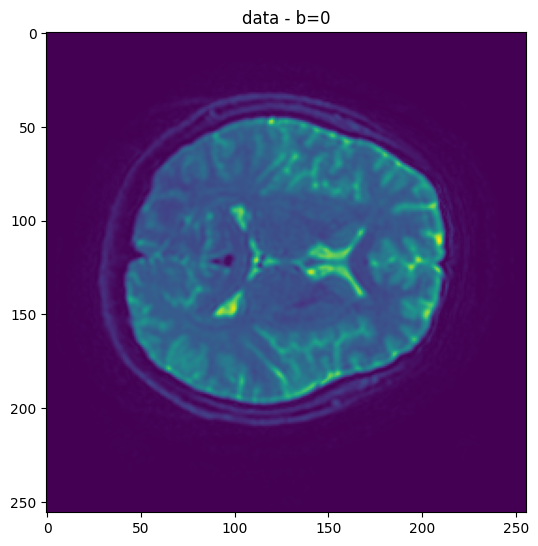

In [3]:
fig1 = plt.figure()
ax1 = fig1.add_axes([0,0,1,1])
ax1.imshow(np.reshape(data, data_shape)[:,:,15,0])
ax1.set_title('data - b=0')

In [4]:
pars = np.empty(pars_dipy.shape, pars_dipy.dtype)

convolve = False
if convolve:
    kernel_size = 20
    avg_kernel = np.ones((kernel_size,kernel_size))/(kernel_size**2)

    pars = np.empty(pars_dipy.shape, pars_dipy.dtype)

    for i in range(0,pars.shape[2]):
        for j in range(0,4):
            pars[:,:,i,j] = signal.convolve2d(pars_dipy[:,:,i,j], avg_kernel, boundary='symm', mode='same')
else:
    pars = pars_dipy.copy()


In [5]:

def param_printer(pars, slicez=15, clim=[0.0, 16000], viewport=[[0.0, 1.0], [0.0, 1.0]], print_S0=False, print_f=False, print_D1=False, print_D2=False):
	xlen = pars.shape[0]
	ylen = pars.shape[1]
	xstart = round(xlen*viewport[0][0])
	xend = round(xlen*viewport[0][1])
	ystart = round(ylen*viewport[1][0])
	yend = round(ylen*viewport[1][1])

	if print_S0:
		fig1 = plt.figure()
		ax1 = fig1.add_axes([0,0,1,1])
		figdata = ax1.imshow(pars[xstart:xend,ystart:yend,slicez,0])
		ax1.set_title('S0')
		figdata.set_clim(clim[0], clim[1])
		fig1.colorbar(figdata, ax=ax1)
		
	if print_f:
		fig1 = plt.figure()
		ax1 = fig1.add_axes([0,0,1,1])
		figdata = ax1.imshow(pars[xstart:xend,ystart:yend,slicez,1])
		ax1.set_title('f')
		figdata.set_clim(clim[0], clim[1])
		fig1.colorbar(figdata, ax=ax1)

	if print_D1:
		fig1 = plt.figure()
		ax1 = fig1.add_axes([0,0,1,1])
		figdata = ax1.imshow(pars[xstart:xend,ystart:yend,slicez,2])
		ax1.set_title('D1')
		figdata.set_clim(clim[0], clim[1])
		fig1.colorbar(figdata, ax=ax1)

	if print_D2:
		fig1 = plt.figure()
		ax1 = fig1.add_axes([0,0,1,1])
		figdata = ax1.imshow(pars[xstart:xend,ystart:yend,slicez,3])
		ax1.set_title('D2')
		figdata.set_clim(clim[0], clim[1])
		fig1.colorbar(figdata, ax=ax1)


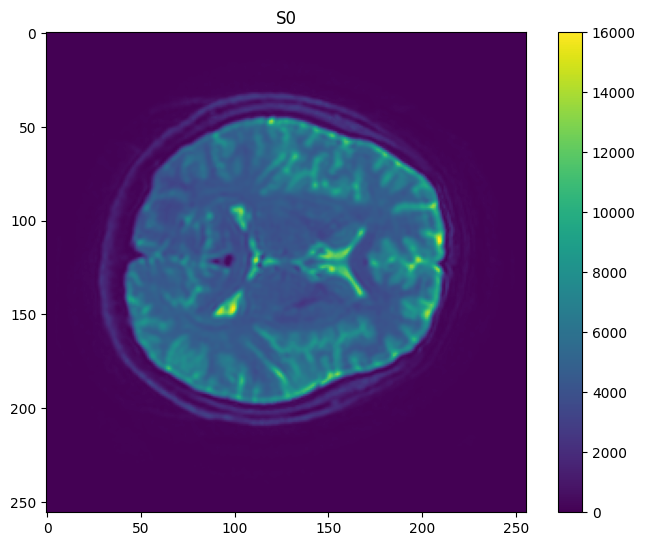

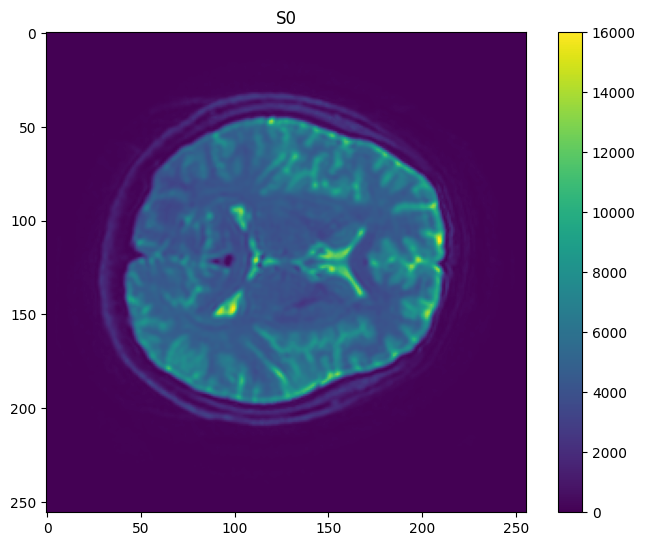

In [6]:
param_printer(pars, print_S0=True)
param_printer(pars_dipy, print_S0=True)

In [7]:
pars_flat = np.reshape(np.transpose(pars, (3,0,1,2)), (4, nvoxels)).copy()
#pars_flat_back = np.transpose(np.reshape(pars_flat, (4, data_shape[0], data_shape[1], data_shape[2])), (1,2,3,0))
#param_printer(pars, print_D2=True)
#param_printer(pars_flat_back, print_D2=True)

In [9]:
import cuda.lsqnonlin as clsq
importlib.reload(clsq)

expr = 'S0*(f*exp(-b*D_1)+(1-f)*exp(-b*D_2))'
pars_str = ['S0', 'f', 'D_1', 'D_2']
consts_str = ['b']

nchunks = 8 
chunk_size = math.ceil(nvoxels / nchunks)

first_f = np.empty((1,nvoxels), dtype=np.float32)
last_f = np.empty((1, nvoxels), dtype=np.float32)

solm = clsq.SecondOrderLevenbergMarquardt(expr, pars_str, consts_str, ndata=21, dtype=cp.float32, write_to_file=True)

start = time.time()
for i in range(0,nchunks):

	parscu = cp.array(pars_flat[:,i*chunk_size:(i+1)*chunk_size], dtype=cp.float32, copy=True)
	constscu = cp.array(consts[:,i*chunk_size*ndata:(i+1)*chunk_size*ndata], dtype=cp.float32, copy=True)
	datacu = cp.array(data_flat[:,i*chunk_size*ndata:(i+1)*chunk_size*ndata], dtype=cp.float32, copy=True)
	lower_bound_cu = cp.array(lower_bound[:,i*chunk_size:(i+1)*chunk_size], dtype=cp.float32, copy=True)
	upper_bound_cu = cp.array(upper_bound[:,i*chunk_size:(i+1)*chunk_size], dtype=cp.float32, copy=True)

	solm.setup(parscu, constscu, datacu, lower_bound_cu, upper_bound_cu)
	solm.run(50, 1e-5)
	
	first_f[:,i*chunk_size:(i+1)*chunk_size] = solm.first_f.get()
	last_f[:,i*chunk_size:(i+1)*chunk_size] = solm.last_f.get()

	pars_flat[:,i*chunk_size:(i+1)*chunk_size] = parscu.get()

cp.cuda.stream.get_current_stream().synchronize()
end = time.time()
print('It took: ' + str(end - start) + ' s')



It took: 334.9395728111267 s


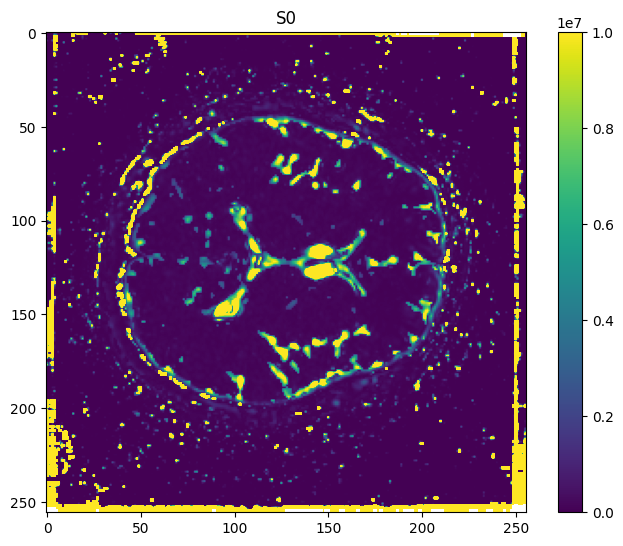

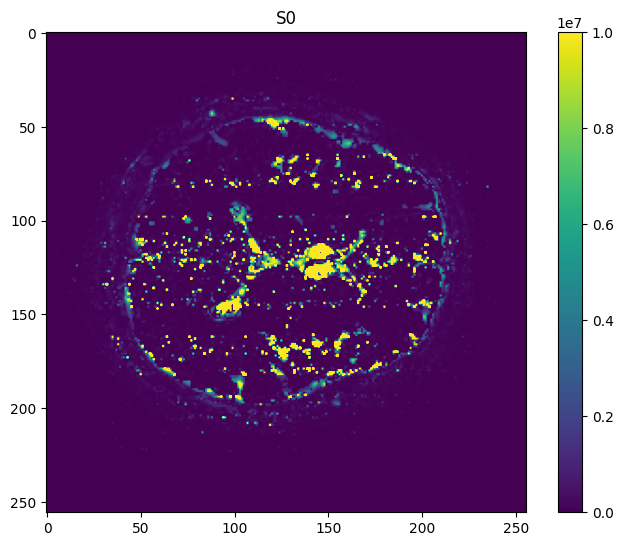

In [18]:
ffig1 = plt.figure()
fax1 = ffig1.add_axes([0,0,1,1])
ffigdata1 = fax1.imshow(np.reshape(first_f, (data_shape[0], data_shape[1], data_shape[2]))[:,:,15])
fax1.set_title('First Objective Functions')
ffigdata1.set_clim(0.0, 1e7)
ffig1.colorbar(ffigdata1, ax=fax1)

ffig2 = plt.figure()
fax2 = ffig2.add_axes([0,0,1,1])
ffigdata2 = fax2.imshow(np.reshape(last_f, (data_shape[0], data_shape[1], data_shape[2]))[:,:,15])
fax2.set_title('Last Objective Functions')
ffigdata2.set_clim(0.0, 1e7)
ffig2.colorbar(ffigdata2, ax=fax2)

In [10]:
pars_flat_back = np.transpose(np.reshape(pars_flat, (4, data_shape[0], data_shape[1], data_shape[2])), (1,2,3,0))


In [11]:
gemask = pars_flat_back[:,:,:,2] < pars_flat_back[:,:,:,3]

temp = pars_flat_back[gemask, 2].copy()
pars_flat_back[gemask, 2] = pars_flat_back[gemask, 3].copy()
pars_flat_back[gemask, 3] = temp.copy()
pars_flat_back[gemask, 1] = 1 - pars_flat_back[gemask, 1]


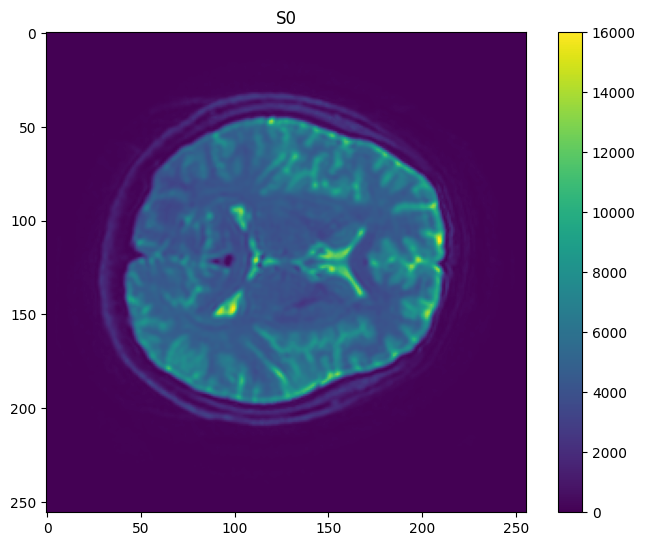

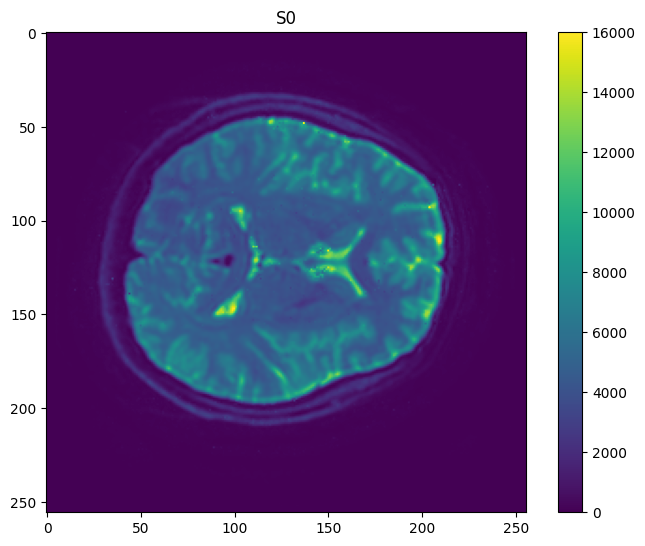

In [12]:
#param_printer(pars, print_S0=True)
param_printer(pars_dipy, slicez=15, clim=[0.0, 16000], viewport=[[0.0, 1.0],[0.0, 1.0]], print_S0=True)

param_printer(pars_flat_back, slicez=15, clim=[0.0, 16000], viewport=[[0.0, 1.0],[0.0, 1.0]], print_S0=True)


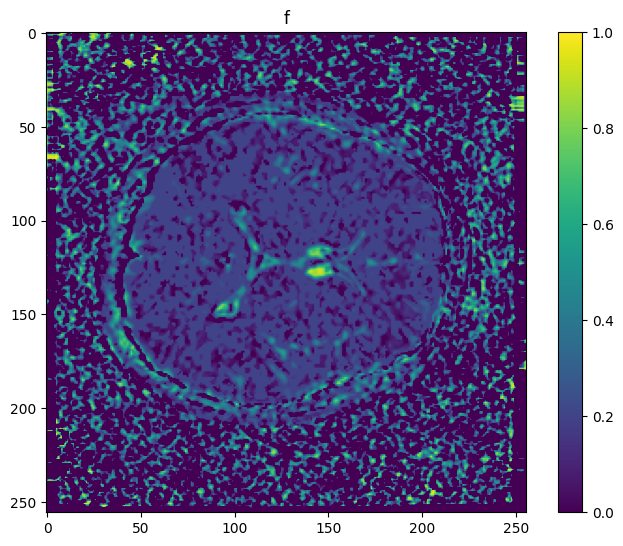

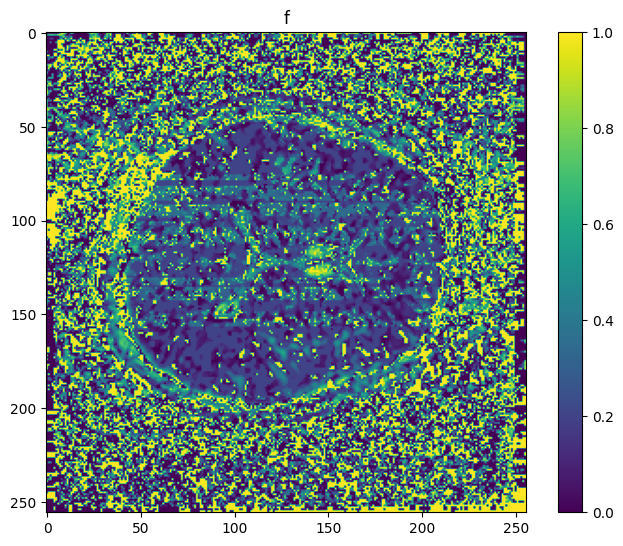

In [13]:
#param_printer(pars, print_S0=True)
param_printer(pars_dipy, slicez=15, clim=[0.0, 1.0], viewport=[[0.0, 1.0],[0.0, 1.0]], print_f=True)

param_printer(pars_flat_back, slicez=15, clim=[0.0, 1.0], viewport=[[0.0, 1.0],[0.0, 1.0]], print_f=True)


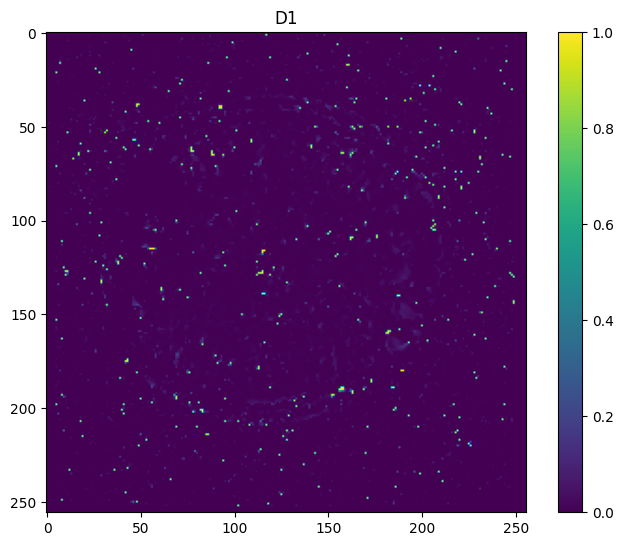

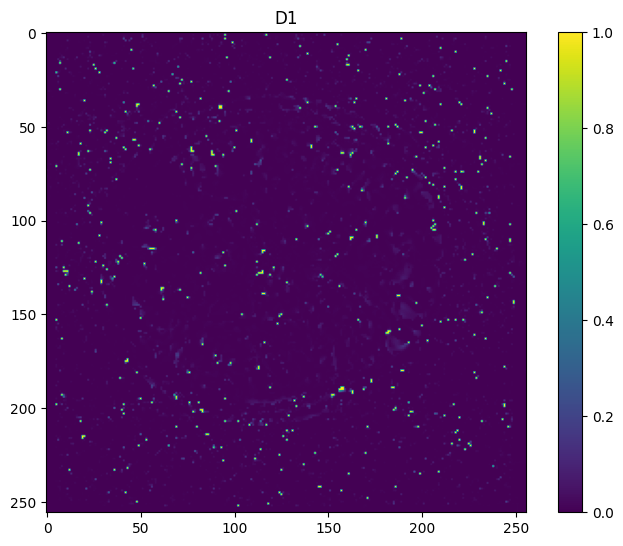

In [14]:
#param_printer(pars, print_S0=True)
param_printer(pars_dipy, slicez=15, clim=[0.0, 1.0], viewport=[[0.0, 1.0],[0.0, 1.0]], print_D1=True)

param_printer(pars_flat_back, slicez=15, clim=[0.0, 1.0], viewport=[[0.0, 1.0],[0.0, 1.0]], print_D1=True)


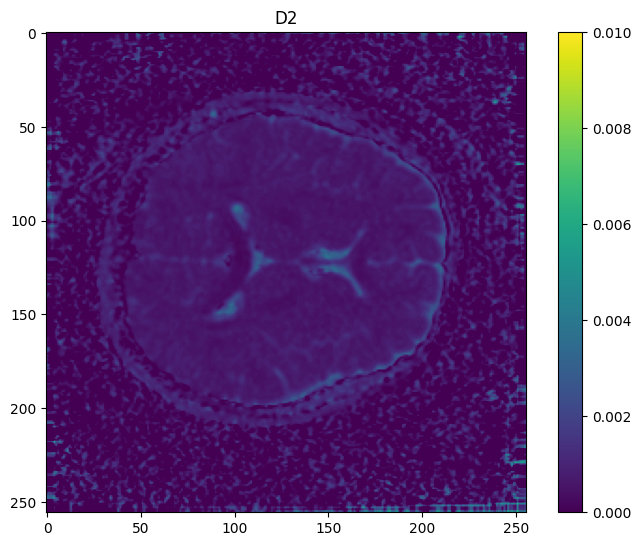

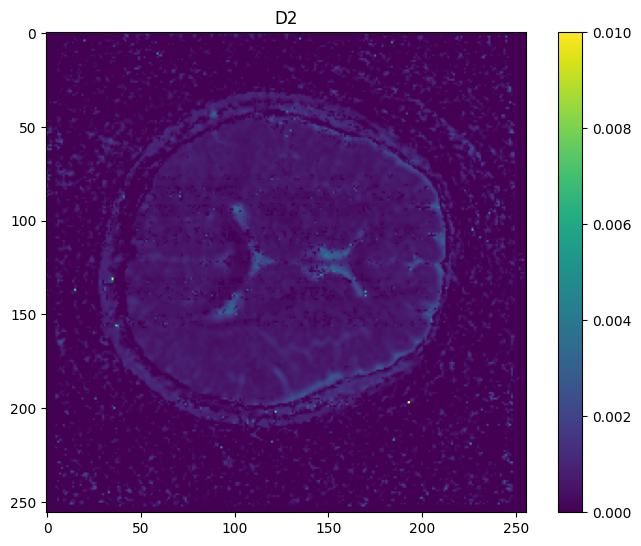

In [15]:
#param_printer(pars, print_S0=True)
param_printer(pars_dipy, slicez=15, clim=[0.0, 0.01], viewport=[[0.0, 1.0],[0.0, 1.0]], print_D2=True)

param_printer(pars_flat_back, slicez=15, clim=[0.0, 0.01], viewport=[[0.0, 1.0],[0.0, 1.0]], print_D2=True)
